In [1]:
print('Importing...')

%matplotlib inline

import glob
import os
import numpy as np
import time as systime
import re 
import textgrid as tg
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from bokeh.plotting import show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from ipyparallel import Client
import _pickle as pickle

import sys

print('success')

Importing...
success


- we need to start with a top level string 
- do some edit operations to get bottom level
- have each bottom level type index a 3-state hmm
- for each 3 state hmm
	- sample some transitions etc 
	- have each state index a GMM
	- each GMM generate a 2-dimensional vector 
    
- input: top level string
- parameters we need to specify: 
	- edit operation parameters
		- ins_top (1)
		- ins_bot (n)
		- sub (n) 
	- hmm 
		- initial (3)
		- transition (3x3)
		- emission (3xm)
    - GMM
		- num of components 
		- mean, variance for each component 
		- mixture proportions 

for simplicity, let's make all top level strings 10 characters long.
let's have a 4 character alphabet 

In [2]:
top_alphabet = [0,1,2,3]
print('success')

success


 let's have 1 more bottom level PLU



In [3]:
bot_alphabet = [0,1,2,3,4]
print('success')

success


Now we get some random sequences of top letters that represent a top alphabet

In [4]:
top_strings = np.random.choice(top_alphabet, (100, 10))
print('success')

success


Now we define prob distributions over ins, sub, del, and sample edit operations for each top-level PLU

In [5]:
# Dirichlet parameters for distribution over edit ops for each of the top PLUs 
# (plus distribution over final insert bottoms)
# (insert_top prob) (insert_bottom probs) (sub probs)
ops_priors = [
    [1,1,2,1,1,1,3,2,1,1,1],
    [2,1,1,2,1,1,1,3,2,1,1],
    [3,1,1,1,2,1,1,1,3,1,1],
    [3,2,1,1,1,1,1,2,1,3,1],

]

# ops_priors = [
#     [1,.1,.1,.1,.1,.1,3,2,1,1,1],
#     [2,.1,.1,.1,.1,.1,1,3,2,1,1],
#     [3,.1,.1,.1,.1,.1,1,1,3,1,1],
#     [3,.1,.1,.1,.1,.1,1,2,1,3,1],
# ]

# Draw a sample from each Dirichlet to get the distribution
ops_dists = [np.random.dirichlet(i) for i in ops_priors]

# ins_top = [2]
# ins_bot = [.5,1,.5,4,2]
# sub = [[100, 3, 4, 1],
#       [.5, 100, 2, 2],
#       [2, .75, 100, 3],
#       [3,2,1,100]]


# full_dir = np.array(ins_top + ins_bot + sub[0] + sub[1] + sub[2] + sub[3], dtype=np.float64)
# # normalize 
# full_dir = full_dir/np.sum(full_dir)
# print(full_dir)

print('success')


success


In [6]:
bottom_strings = []
i = 0
while i < len(top_strings):
    ts = top_strings[i]
    j = 0
    bs = []
    while j < len(ts):
#         sample some edit operation
#         eo = np.argmax(np.random.multinomial(1, full_dir))
        eo = np.argmax(np.random.multinomial(1, ops_dists[ts[j]]))
#         print(ops_dists[ts[j]])
#         print(eo)
        if eo == 0:
#             insert top, do nothing
            j+=1
        elif eo >= 1 and eo <= 5:
            bc = bot_alphabet[eo-1]
            bs.append(bc)
        else:
#             sub
#             bc = bot_alphabet[(eo-5)%4]
            bc = bot_alphabet[(eo-6)] 
            bs.append(bc)
            j+=1
    i+=1
    print("num of top string PLUs: ", len(ts))
    print("num of bottom string PLUs: ", len(bs))
    print("\n")
    bottom_strings.append(bs)

print(bottom_strings)
print(len(bottom_strings[0]))



num of top string PLUs:  10
num of bottom string PLUs:  18


num of top string PLUs:  10
num of bottom string PLUs:  15


num of top string PLUs:  10
num of bottom string PLUs:  9


num of top string PLUs:  10
num of bottom string PLUs:  18


num of top string PLUs:  10
num of bottom string PLUs:  17


num of top string PLUs:  10
num of bottom string PLUs:  9


num of top string PLUs:  10
num of bottom string PLUs:  10


num of top string PLUs:  10
num of bottom string PLUs:  21


num of top string PLUs:  10
num of bottom string PLUs:  11


num of top string PLUs:  10
num of bottom string PLUs:  13


num of top string PLUs:  10
num of bottom string PLUs:  10


num of top string PLUs:  10
num of bottom string PLUs:  18


num of top string PLUs:  10
num of bottom string PLUs:  19


num of top string PLUs:  10
num of bottom string PLUs:  16


num of top string PLUs:  10
num of bottom string PLUs:  11


num of top string PLUs:  10
num of bottom string PLUs:  8


num of top string PLUs:  10

Let's define the HMM/GMM parameters

In [7]:
# transition = [[.5, .5, 0],
#              [0, .5, .5],
#              [.75, 0, .25]]

components = []
# Distribution over components for each bottom PLU state
components.append([[.7,.3],
             [.9,.1],
             [.3,.7]])
components.append([[.3,.7],
             [.5,.5],
             [.8,.2]])
components.append([[.4,.6],
             [.2,.8],
             [.9,.1]])
components.append([[.5,.5],
             [.3,.7],
             [.6,.4]])
components.append([[.1,.9],
             [.6,.4],
             [.7,.3]])


# We need a set of parameters for each component
# for each HMM state for each bottom PLU
# So in this case, we need 2 * 3 * 5 = 30 sets of parameters
component_parameters = [
    [
        [
            [[0,0], [[1,0],[0,1]]], # bottom PLU 0, HMM state 0, component 0
            [[0.1,0.1], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 0, component 1
        ],
        [
             [[0.2,0.2], [[1,0],[0,1]]], # bottom PLU 0, HMM state 1, component 0
             [[0.3,0.03], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 1, component 1
        ],
        [
            [[0.4,0.4], [[1,0],[0,1]]], # bottom PLU 0, HMM state 2, component 0
            [[0.5,0.5], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 2, component 1
        ]
    ],
    [
        [
            [[1.0,1.0], [[1,0],[0,1]]], # bottom PLU 1, HMM state 0, component 0
            [[1.1,1.1], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 0, component 1
        ],
        [
             [[1.2,1.2], [[1,0],[0,1]]], # bottom PLU 1, HMM state 1, component 0
             [[1.3,1.3], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 1, component 1
        ],
        [
            [[1.4,1.4], [[1,0],[0,1]]], # bottom PLU 1, HMM state 2, component 0
            [[1.5,1.5], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 2, component 1
        ]
    ],
    [        
        [
            [[2.0,2.0], [[1,0],[0,1]]], # bottom PLU 2, HMM state 0, component 0
            [[2.1,2.1], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 0, component 1
        ],
        [
             [[2.2,2.2], [[1,0],[0,1]]], # bottom PLU 2, HMM state 1, component 0
             [[2.3,2.3], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 1, component 1
        ],
        [
            [[2.4,2.4], [[1,0],[0,1]]], # bottom PLU 2, HMM state 2, component 0
            [[2.5,2.5], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 2, component 1
        ]
    ],
    [
        [
            [[3.0,3.0], [[1,0],[0,1]]], # bottom PLU 3, HMM state 0, component 0
            [[3.1,3.1], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 0, component 1
        ],
        [
             [[3.2,3.2], [[1,0],[0,1]]], # bottom PLU 3, HMM state 1, component 0
             [[3.3,3.3], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 1, component 1
        ],
        [
            [[3.4,3.4], [[1,0],[0,1]]], # bottom PLU 3, HMM state 2, component 0
            [[3.5,3.5], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 2, component 1
        ]
    ],
    [
        [
            [[4.0,4.0], [[1,0],[0,1]]], # bottom PLU 4, HMM state 0, component 0
            [[4.1,4.1], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 0, component 1
        ],
        [
             [[4.2,4.2], [[1,0],[0,1]]], # bottom PLU 4, HMM state 1, component 0
             [[4.3,4.3], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 1, component 1
        ],
        [
            [[4.4,4.4], [[1,0],[0,1]]], # bottom PLU 4, HMM state 2, component 0
            [[4.5,4.5], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 2, component 1
        ]
    ]


]

print('success')
# n1 = [[0,0], [[1,0],[0,1]]]
# n2 = [[10, 10], [[1,0],[0,1]]]


success


In [8]:
print('running...')

def sample_HMMGMM(bs):
    mfccs = []
    for i, char in enumerate(bs):
        vec = None
#         if i%10 == 0:
#             print("done with ", i)
#         start_state = np.random.choice([0,1,2], p=init)
        curr_state = 0
#       get the mfcc vector and transition
        while curr_state < 3:
            gmm_component_choice = np.random.choice(2,p=components[char][curr_state])
            vec = np.random.multivariate_normal(*component_parameters[char][curr_state][gmm_component_choice])
#             vec = components[curr_state][0]*np.random.multivariate_normal(*n1) + \
#                     components[curr_state][1]*np.random.multivariate_normal(*n2)
            
            mfccs.append(vec)
#             new_curr_state = np.random.choice([0,1,2], p=transition[curr_state])
            # Transition to next state with 50% probability
            curr_state = np.random.choice([curr_state,curr_state+1],p=[0.5,0.5])
#             if curr_state == 2 and new_curr_state == 0:
    #         get the mfcc vector and transition
#             curr_state = new_curr_state
    return np.array(mfccs)

all_data = []


for i, bs in enumerate(bottom_strings):
    print("num of bottom PLUs: ", len(bs))
    mfccs = sample_HMMGMM(bs)
    print("num of frames: ", mfccs.shape[0])
    print("frames per PLU: ", mfccs.shape[0]/float(len(bs)))
    
    all_data.append(mfccs)

print(all_data[0].shape)

print('success')
        
# for i,line in enumerate(all_data):
#     with open("/Users/esteng/ULD/audio/example_2d/sent_{}.fea", "w") as f1:
        
        

running...
num of bottom PLUs:  18
num of frames:  94
frames per PLU:  5.222222222222222
num of bottom PLUs:  15
num of frames:  98
frames per PLU:  6.533333333333333
num of bottom PLUs:  9
num of frames:  52
frames per PLU:  5.777777777777778
num of bottom PLUs:  18
num of frames:  107
frames per PLU:  5.944444444444445
num of bottom PLUs:  17
num of frames:  105
frames per PLU:  6.176470588235294
num of bottom PLUs:  9
num of frames:  56
frames per PLU:  6.222222222222222
num of bottom PLUs:  10
num of frames:  66
frames per PLU:  6.6
num of bottom PLUs:  21
num of frames:  111
frames per PLU:  5.285714285714286
num of bottom PLUs:  11
num of frames:  58
frames per PLU:  5.2727272727272725
num of bottom PLUs:  13
num of frames:  81
frames per PLU:  6.230769230769231
num of bottom PLUs:  10
num of frames:  65
frames per PLU:  6.5
num of bottom PLUs:  18
num of frames:  119
frames per PLU:  6.611111111111111
num of bottom PLUs:  19
num of frames:  97
frames per PLU:  5.105263157894737


In [9]:
def collect_data_stats(data):
    """Job to collect the statistics."""
    # We  re-import this module here because this code will run
    # remotely.
    
    stats_0 = data.shape[0]
    stats_1 = data.sum(axis=0)
    stats_2 = (data**2).sum(axis=0)
    retval = (
        stats_0,
        stats_1,
        stats_2
    )
    return retval

data_stats = list(map(collect_data_stats, all_data))

print('success')

success


In [10]:

def accumulate_stats(data_stats):
    n_frames = data_stats[0][0]
    mean = data_stats[0][1]
    var = data_stats[0][2]
    for stats_0, stats_1, stats_2 in data_stats[1:]:
        n_frames += stats_0
        mean += stats_1
        var += stats_2
    mean /= n_frames
    var = (var / n_frames) - mean**2

    data_stats = {
        'count': n_frames,
        'mean': mean,
        'var': var
    }
    return data_stats

final_data_stats = accumulate_stats(data_stats)

print('success')

success


In [11]:
print("Running...")

import subprocess
import amdtk
num_tops = 4

print("Finished imports in ipython notebook.")

print(len(all_data))
print(len(top_strings))
all_data_and_tops = list(zip(all_data, top_strings))
#print(all_data_and_tops[0])

print("starting engines")
subprocess.Popen(['ipcluster', 'start',' --profile', 'default',' -n', '4', '--daemonize'])
subprocess.Popen(['sleep', '10']).communicate()


rc = Client(profile='default')
dview = rc[:]
print('Connected to', len(dview), 'jobs.')


elbo = []
time = []
def callback(args):
    elbo.append(args['lower_bound'])
    time.append(args['time'])
    print('elbo=' + str(elbo[-1]), 'time=' + str(time[-1]))
 

print("Creating phone loop model...")
conc = 0.1

n_units=5  # number of acoustic units
n_states=3   # number of states per unit
n_comp_per_state=3   # number of Gaussians per emission


model = amdtk.PhoneLoopNoisyChannel.create(
    n_units=n_units,  # number of acoustic units
    n_states=n_states,   # number of states per unit
    n_comp_per_state=n_comp_per_state,   # number of Gaussians per emission
    n_top_units=num_tops, # size of top PLU alphabet
    mean=np.zeros_like(final_data_stats['mean']), 
    var=np.ones_like(final_data_stats['var']),
    max_slip_factor=.05
    #concentration=conc
)


print("Creating VB optimizer...")   
optimizer = amdtk.ToyNoisyChannelOptimizer(
    dview, 
    final_data_stats, 
    args= {'epochs': 3,
     'batch_size': 4,
     'lrate': 0.01,
     'pkl_path': "example_test",
     'log_dir': 'logs'},
    model=model,
    dir_path='dir'
)

print("Running VB optimization...")
begin = systime.time()
print("running with toy data")
print('len(all_data_and_tops[0])')
print(len(all_data_and_tops[0]))
optimizer.run(all_data_and_tops, callback)
end = systime.time()
print("VB optimization took ",end-begin," seconds.")

# fig1 = figure(
#     x_axis_label='time (s)', 
#     y_axis_label='ELBO',
#     width=400, 
#     height=400
# )
# x = np.arange(0, len(elbo), 1)
# fig1.line(x, elbo)
#show(fig1)

print("\nDECODING\n")

date_string = systime.strftime("textgrids_%Y-%m-%d_%H:%M")

# Need to change this according to 
samples_per_sec = 100

all_data_and_tops = list(zip(all_data, top_strings))

for data, tops in all_data_and_tops:

    # Normalize the data
    data_mean = np.mean(data)
    data_var = np.var(data)
    data = (data-data_mean)/np.sqrt(data_var)

    #result = model.decode(data, tops, state_path=False)
    #result_path = model.decode(data, tops, state_path=True)
    (result_intervals, edit_path, plu_path) = model.decode(data, tops, phone_intervals=True, edit_ops=True)

    print("---")
    print("Phone sequence:")
    print(result_intervals)
    print(edit_path)
    

Running...
INSIDE INIT
SUCCESSFUL IMPORT IN INIT
Finished imports in ipython notebook.
100
100
starting engines
Connected to 4 jobs.
Creating phone loop model...
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
Creating VB optimizer...
Running VB optimization...
running with toy data
len(all_data_and_tops[0])
2
state_llh at 9.049694:
(94, 15)
Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -296.196158822
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

Frames: 105   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -327.19259578
checking indices:
{104, 105}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]
total states: 62465
forward states: 49686
b

Frames: 58   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -185.780633579
checking indices:
{57, 58}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
total states: 32980
forward states: 26856
backward states: 23535
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-185.72430749, -187.32281839, -187.9283776 , -188.22735715,
       -187.01956861, -187.07772978, -185.9165083 , -186.60695637,
       -186.52578652, -185.49984208, -185.8408971 ]), array([-186.35321103, -188.13254466, -188.37148907, -189.1934236 ,
     

Frames: 97   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -320.913567176
checking indices:
{96, 97}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
total states: 57900
forward states: 46191
backward states: 47360
ends in forward:  15
ends in backward:  30
starts in f

Frames: 85   Pb types: 5   Pt types: 3   Pt indices: 10
end item total:  -261.861988864
checking indices:
{84, 85}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
total states: 49515
forward states: 39636
backward states: 39255
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-261.46336548, -262.71575187, -263.17

Frames: 93   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -285.050375017
checking indices:
{92, 93}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
total states: 54080
forward states: 43131
backward states: 43540
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward: 

Frames: 79   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -243.10105909
checking indices:
{78, 79}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
total states: 46860
forward states: 37671
backward states: 36880
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-242.36234592, -244.00088703, -244.17257601, -246.06478673,
       -243.8264999 , -243

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -293.782079079
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in ba

Frames: 81   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -249.359803471
checking indices:
{80, 81}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
total states: 45700
forward states: 36596
backward states: 35470
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-249.89117185, -251.4114494 , -251.66304669, -253.01538783,
       -2

Frames: 61   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -197.227411315
checking indices:
{60, 61}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
total states: 32800
forward states: 26576
backward states: 23150
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-198.57557463, -199.77375199, -200.56269723, -202.82869568,
       -200.57699456, -199.9361642 , -198.4524301 , -199.24342288,
       -201.13479906, -199.0823157 , -198.5741182 ]), array([-197.7698505 , -199.60062432, -199.400237

Frames: 55   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -187.079174378
checking indices:
{54, 55}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
total states: 30105
forward states: 24566
backward states: 20680
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-188.20090393, -189.7752752 , -190.37874528, -191.25650946,
       -190.16518127, -189.53833856, -188.39542896, -188.93352166,
       -189.5948691 , -188.65084761, -188.24826655]), array([-187.9258267 , -188.95028112, -190.20906675, -192.41745401,
       -190.76816624, -189.87

Frames: 63   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -209.141610017
checking indices:
{62, 63}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
total states: 34660
forward states: 28076
backward states: 24990
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-209.37544641, -210.51353617, -211.26507667, -212.08971171,
       -211.18736925, -211.52667372, -209.25447475, -209.70883302,
       -210.86062379, -210.02218595, -210.1277418 ]), array([-208.66249859, -209.95889

Frames: 74   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -233.402067746
checking indices:
{73, 74}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
total states: 42080
forward states: 33846
backward states: 32105
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-235.040898  , -236.2734898 , -237.08239888, -238.87874712,
       -237.10334135, -236.52197094, -234.85023059, -235.79464512

Frames: 49   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -169.589090542
checking indices:
{48, 49}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
total states: 27460
forward states: 22516
backward states: 18295
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-169.04287156, -170.67941194, -171.19107221, -172.07079266,
       -171.28434396, -171.17521079, -169.2269725 , -169.63507146,
       -170.50939005, -169.82098761, -169.7285328 ]), array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]), array([-170.29117915, -171.43306515, -172.12282149, -172.87975209,
  

Frames: 67   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -214.752191364
checking indices:
{66, 67}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
total states: 38475
forward states: 31116
backward states: 28775
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-215.16971103, -216.76417473, -217.74070921, -217.70117817,
       -216.31982952, -216.68333508, -215.49355886, -216.42312485,
       -216.5841421 , -215.10622533, -215.31183536]), 

Frames: 59   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -194.08452399
checking indices:
{58, 59}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
total states: 33935
forward states: 27621
backward states: 24490
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-194.56650277, -195.87674469, -196.43564551, -198.24694245,
       -197.02180749, -195.85172235, -194.47426331, -195.09207321,
       -196.81692728, -195.4152381 , -194.51776033]), array([-193.95977506, -195.53640976, -196.23603591, -197.22995028

Frames: 54   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -167.179539611
checking indices:
{53, 54}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
total states: 29165
forward states: 23816
backward states: 19750
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-168.87196416, -170.57767891, -170.55815656, -172.55034996,
       -170.91353086, -170.08507804, -169.32456248, -169.3854061 ,
       -171.10866024, -169.20996533, -168.84056282]), array([-169.11279188, -169.50486251, -170.04150921, -172.15799026,
       -170.04425153, -169.18478521, 

Frames: 90   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -285.679149157
checking indices:
{89, 90}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
total states: 54290
forward states: 43461
backward states: 44030
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[arra

Frames: 76   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -230.787855575
checking indices:
{75, 76}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
total states: 43995
forward states: 35376
backward states: 34015
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-230.78051379, -232.05479781, -232.56819629, -234.59390904,
       -233.14617349, -231.96429351, -230.8250401

Frames: 73   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -227.387624521
checking indices:
{72, 73}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
total states: 41120
forward states: 33086
backward states: 31160
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-228.38690767, -229.04215306, -230.23111671, -231.86353081,
       -231.674718  , -230.24017095, -227.90386483, -228.89671178,
      

Frames: 90   Pb types: 5   Pt types: 3   Pt indices: 10
end item total:  -292.295565567
checking indices:
{89, 90}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
total states: 54290
forward states: 43461
backward states: 44030
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[arra

Frames: 81   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -247.621296931
checking indices:
{80, 81}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
total states: 45700
forward states: 36596
backward states: 35470
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-247.07582693, -248.43799792, -249.25147913, -250.93035863,
       -2

Frames: 57   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -184.481588204
checking indices:
{56, 57}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
total states: 32025
forward states: 26091
backward states: 22580
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-184.44550981, -186.10641909, -186.17774694, -187.33711573,
       -186.30454831, -185.95486224, -184.77130285, -184.89673002,
       -185.93676057, -184.89890808, -184.64163348]), array([-187.37075193, -187.36024439, -188.05263152, -188.10472912,
       -187.2

Frames: 84   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -267.594504736
checking indices:
{83, 84}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
total states: 48560
forward states: 38871
backward states: 38300
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-268.00703488, -268.97019865, -270.44563244, 

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -293.289356846
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in ba

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -155.357785365
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in ba

Frames: 105   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -196.999773018
checking indices:
{104, 105}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]
total states: 62465
forward states: 49686


Frames: 58   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -149.007148569
checking indices:
{57, 58}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
total states: 32980
forward states: 26856
backward states: 23535
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-149.28675842, -151.10200248, -153.69473988, -153.49716732,
       -150.01264084, -151.92481354, -149.66461537, -152.4433383 ,
       -152.47526483, -148.17808431, -150.45171699]), array([-150.0257886 , -151.69784457, -154.38538004, -154.64973395,
     

Frames: 97   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -190.584224262
checking indices:
{96, 97}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
total states: 57900
forward states: 46191
backward states: 47360
ends in forward:  15
ends in backward:  30
starts in f

Frames: 85   Pb types: 5   Pt types: 3   Pt indices: 10
end item total:  -164.512464975
checking indices:
{84, 85}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
total states: 49515
forward states: 39636
backward states: 39255
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-164.7863788 , -166.37883315, -168.68

Frames: 93   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -150.385283365
checking indices:
{92, 93}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
total states: 54080
forward states: 43131
backward states: 43540
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward: 

Frames: 79   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -139.656032928
checking indices:
{78, 79}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
total states: 46860
forward states: 37671
backward states: 36880
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-140.71758857, -142.23395763, -145.02194703, -145.57548897,
       -142.07380746, -14

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -170.012334427
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in ba

Frames: 81   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -170.988144651
checking indices:
{80, 81}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
total states: 45700
forward states: 36596
backward states: 35470
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-171.83881702, -173.54203181, -176.21565101, -176.63927683,
       -1

Frames: 61   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -143.469955885
checking indices:
{60, 61}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
total states: 32800
forward states: 26576
backward states: 23150
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-144.51077304, -146.00050728, -148.30487524, -149.34009656,
       -145.86105872, -146.27916371, -144.62856983, -147.04489874,
       -148.28160102, -144.08153848, -144.94778031]), array([-143.6129642 , -145.78034449, -147.598317

Frames: 55   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -122.073412462
checking indices:
{54, 55}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
total states: 30105
forward states: 24566
backward states: 20680
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-122.68790529, -124.54003799, -126.80403527, -127.19749257,
       -123.5119053 , -125.38237359, -122.8915767 , -125.46350784,
       -126.14472661, -121.85000825, -123.70250741]), array([-122.69585477, -124.87166606, -127.14028212, -128.54832893,
       -123.83646683, -125.28

Frames: 63   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -155.138560612
checking indices:
{62, 63}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
total states: 34660
forward states: 28076
backward states: 24990
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-155.48457554, -157.38763477, -159.55203831, -159.67073232,
       -156.18866482, -157.68941339, -155.88864971, -158.25741531,
       -158.71272177, -154.75355634, -156.25921437]), array([-154.79995077, -156.85223

Frames: 74   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -143.542372165
checking indices:
{73, 74}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
total states: 42080
forward states: 33846
backward states: 32105
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-144.61804925, -146.39975887, -148.95137659, -149.75851214,
       -145.36455634, -146.82940577, -144.95899128, -147.55036024

Frames: 49   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -141.635732062
checking indices:
{48, 49}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
total states: 27460
forward states: 22516
backward states: 18295
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-141.79079269, -144.20173123, -145.93742866, -145.9642824 ,
       -142.75626638, -144.58823033, -142.50623946, -144.33655464,
       -144.58516419, -141.11010218, -142.91206419]), array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]), array([-143.07197312, -144.99946484, -146.95769902, -147.32309454,
  

Frames: 67   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -157.038252164
checking indices:
{66, 67}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
total states: 38475
forward states: 31116
backward states: 28775
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-157.38452962, -159.38655819, -161.8201234 , -161.50685818,
       -158.2585613 , -160.45421128, -157.84946278, -160.47784444,
       -160.37773256, -156.69045866, -158.88382851]), 

Frames: 59   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -152.735923911
checking indices:
{58, 59}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
total states: 33935
forward states: 27621
backward states: 24490
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-153.6515299 , -155.79652135, -158.52438018, -158.57178455,
       -154.43978272, -156.69683079, -154.00112102, -156.85548298,
       -157.13524742, -152.93047059, -154.94963597]), array([-153.17117273, -154.83741111, -157.3612441 , -157.4678551

Frames: 54   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -95.1133052988
checking indices:
{53, 54}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
total states: 29165
forward states: 23816
backward states: 19750
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([ -96.21232512,  -97.91650893, -100.51570517, -101.19200283,
        -96.99483874,  -98.84655373,  -96.35886231,  -99.09401959,
        -99.98319673,  -95.61431399,  -97.34728714]), array([ -96.46927992, -100.54326404, -102.4278286 , -103.85496585,
        -96.03192663, -100.81268652, 

Frames: 90   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -190.934391003
checking indices:
{89, 90}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
total states: 54290
forward states: 43461
backward states: 44030
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[arra

Frames: 76   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -130.073857238
checking indices:
{75, 76}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
total states: 43995
forward states: 35376
backward states: 34015
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-129.97080115, -131.63324324, -134.61018039, -135.1371296 ,
       -131.47031988, -132.40892618, -130.0194645

Frames: 73   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -118.778190338
checking indices:
{72, 73}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
total states: 41120
forward states: 33086
backward states: 31160
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-120.51451111, -122.34083413, -125.06896572, -125.85082727,
       -121.41845438, -122.45281513, -120.81404403, -123.72699562,
      

Frames: 90   Pb types: 5   Pt types: 3   Pt indices: 10
end item total:  -180.524196312
checking indices:
{89, 90}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
total states: 54290
forward states: 43461
backward states: 44030
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[arra

Frames: 81   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -133.460769428
checking indices:
{80, 81}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
total states: 45700
forward states: 36596
backward states: 35470
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-133.00649797, -134.73099846, -137.85910435, -138.46466022,
       -1

Frames: 57   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -117.717626211
checking indices:
{56, 57}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
total states: 32025
forward states: 26091
backward states: 22580
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-118.17871044, -119.96568644, -121.91548683, -123.01532751,
       -119.26875869, -120.86329338, -118.34736731, -120.53719695,
       -121.77317616, -117.47161737, -119.25450502]), array([-126.18686542, -123.50638037, -125.53100421, -126.14677963,
       -120.0

Frames: 84   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -146.66368478
checking indices:
{83, 84}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
total states: 48560
forward states: 38871
backward states: 38300
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-147.02732043, -149.15464356, -151.85994496, -

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -156.303873857
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in ba

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -177.888622285
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in ba

Frames: 105   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -233.842608559
checking indices:
{104, 105}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]
total states: 62465
forward states: 49686


Frames: 58   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -175.038547319
checking indices:
{57, 58}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
total states: 32980
forward states: 26856
backward states: 23535
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-175.61711522, -179.22378628, -183.60156623, -182.88083026,
       -176.23333962, -181.12130349, -177.75065314, -182.53299081,
       -182.0543732 , -174.13450398, -179.78083036]), array([-176.86240319, -179.48699438, -184.45862968, -183.99371907,
     

Frames: 97   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -213.403806515
checking indices:
{96, 97}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
total states: 57900
forward states: 46191
backward states: 47360
ends in forward:  15
ends in backward:  30
starts in f

Frames: 85   Pb types: 5   Pt types: 3   Pt indices: 10
end item total:  -198.901661534
checking indices:
{84, 85}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
total states: 49515
forward states: 39636
backward states: 39255
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-199.6666909 , -202.53815222, -207.32

Frames: 93   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -178.291094088
checking indices:
{92, 93}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
total states: 54080
forward states: 43131
backward states: 43540
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward: 

Frames: 79   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -166.3808297
checking indices:
{78, 79}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
total states: 46860
forward states: 37671
backward states: 36880
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-167.85114354, -170.48440082, -175.34984682, -174.89721347,
       -168.88259596, -172.

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -203.998012145
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in ba

Frames: 81   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -205.646654077
checking indices:
{80, 81}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
total states: 45700
forward states: 36596
backward states: 35470
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-206.72607526, -210.20033441, -214.81297405, -214.31926445,
       -2

Frames: 61   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -166.816258003
checking indices:
{60, 61}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
total states: 32800
forward states: 26576
backward states: 23150
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-168.56731051, -171.15764374, -176.33468589, -175.97615617,
       -169.74736236, -173.53729767, -169.82076559, -175.26873944,
       -175.1358195 , -167.73793853, -172.28724033]), array([-167.98376245, -171.51152027, -175.766152

Frames: 55   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -139.868124775
checking indices:
{54, 55}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
total states: 30105
forward states: 24566
backward states: 20680
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-140.94200403, -144.30074397, -148.95721871, -148.37581502,
       -141.7736109 , -146.34114389, -142.82610145, -147.82679074,
       -147.53216907, -139.89550649, -144.99551838]), array([-141.03240742, -144.50330999, -150.05313376, -150.11314931,
       -141.96065244, -147.11

Frames: 63   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -180.237343614
checking indices:
{62, 63}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
total states: 34660
forward states: 28076
backward states: 24990
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-181.53935908, -185.01971923, -189.57810652, -188.85415043,
       -181.95126358, -187.14828931, -183.36442804, -188.56874395,
       -188.07963364, -180.32487887, -185.67641807]), array([-181.31040534, -184.10744

Frames: 74   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -167.586886848
checking indices:
{73, 74}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
total states: 42080
forward states: 33846
backward states: 32105
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-169.76669975, -172.74789115, -178.03368209, -177.75447129,
       -169.9368486 , -175.14874844, -171.39144257, -176.76261259

Frames: 49   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -160.918265282
checking indices:
{48, 49}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
total states: 27460
forward states: 22516
backward states: 18295
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-161.91218519, -165.55168778, -169.66919715, -168.88109094,
       -162.55595837, -167.6687136 , -163.85640602, -168.17895121,
       -167.61475789, -160.68129258, -166.03372346]), array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]), array([-163.09662431, -165.79825664, -171.04740135, -170.36650417,
  

Frames: 67   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -187.531262482
checking indices:
{66, 67}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
total states: 38475
forward states: 31116
backward states: 28775
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-187.7769589 , -192.11625711, -196.53914308, -195.74419761,
       -188.48638087, -194.00381958, -190.45109196, -195.22844936,
       -194.72781143, -186.75335698, -192.51272282]), 

Frames: 59   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -175.700200421
checking indices:
{58, 59}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
total states: 33935
forward states: 27621
backward states: 24490
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-177.05950365, -182.1557668 , -186.32492879, -185.54536584,
       -177.39744992, -184.05723615, -179.9923086 , -184.40973823,
       -183.8849507 , -175.70863588, -181.97353427]), array([-176.50930506, -179.68982099, -184.52681151, -183.9908081

Frames: 54   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -112.307949015
checking indices:
{53, 54}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
total states: 29165
forward states: 23816
backward states: 19750
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-114.10296947, -117.68189152, -122.07925732, -121.82035647,
       -114.71181812, -119.80030416, -116.07803222, -120.77586581,
       -120.74875621, -113.03652382, -118.28981278]), array([-115.0116168 , -123.37726485, -127.16545283, -128.21866224,
       -113.7385875 , -124.57894079, 

Frames: 90   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -224.902032035
checking indices:
{89, 90}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
total states: 54290
forward states: 43461
backward states: 44030
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[arra

Frames: 76   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -154.229788511
checking indices:
{75, 76}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
total states: 43995
forward states: 35376
backward states: 34015
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-154.77525789, -157.77575353, -162.91020969, -162.53105486,
       -155.91255713, -160.05470831, -156.1463405

Frames: 73   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -138.83155755
checking indices:
{72, 73}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
total states: 41120
forward states: 33086
backward states: 31160
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-140.64450643, -143.64817174, -149.31966816, -148.98511927,
       -141.26866099, -145.92726281, -142.04257977, -148.01453677,
       

Frames: 90   Pb types: 5   Pt types: 3   Pt indices: 10
end item total:  -203.621054144
checking indices:
{89, 90}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
total states: 54290
forward states: 43461
backward states: 44030
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[arra

Frames: 81   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -158.272921804
checking indices:
{80, 81}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
total states: 45700
forward states: 36596
backward states: 35470
ends in forward:  10
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-158.48187158, -161.43799298, -166.82713056, -166.49196895,
       -1

Frames: 57   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -137.32347725
checking indices:
{56, 57}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
total states: 32025
forward states: 26091
backward states: 22580
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-138.6778902 , -141.43915904, -145.9780268 , -145.72952506,
       -139.10579214, -143.65163667, -139.95235616, -144.723869  ,
       -144.67531397, -137.02567081, -142.22269404]), array([-147.32690278, -149.65804971, -152.31555945, -153.82553244,
       -139.88

Frames: 84   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -169.977452696
checking indices:
{83, 84}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
total states: 48560
forward states: 38871
backward states: 38300
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in backward:  11
log op counts:
[array([-171.08815511, -174.37241543, -179.34388228, 

Frames: 94   Pb types: 5   Pt types: 4   Pt indices: 10
end item total:  -185.04092793
checking indices:
{93, 94}
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
total states: 55035
forward states: 43896
backward states: 44495
ends in forward:  15
ends in backward:  30
starts in forward:  11
starts in bac

BEST END ITEM:
(93, 2, 0, 9, 3, 9)
---
Phone sequence:
[(4, 0, 5), (0, 5, 15), (3, 15, 25), (0, 25, 35), (3, 35, 40), (4, 40, 50), (1, 50, 64), (0, 64, 72), (3, 72, 80), (0, 80, 94)]
[('SUB', 0, 4), ('SUB', 0, 0), ('SUB', 1, 3), ('SUB', 2, 0), ('SUB', 1, 3), ('SUB', 2, 4), ('SUB', 1, 1), ('SUB', 3, 0), ('SUB', 3, 3), ('SUB', 3, 0)]
BEST END ITEM:
(97, 2, 0, 9, 3, 9)
---
Phone sequence:
[(3, 0, 4), (4, 4, 12), (0, 12, 21), (4, 21, 34), (3, 34, 40), (1, 40, 50), (0, 50, 62), (4, 62, 80), (3, 80, 85), (0, 85, 98)]
[('SUB', 0, 3), ('SUB', 0, 4), ('SUB', 1, 0), ('SUB', 0, 4), ('SUB', 2, 3), ('SUB', 1, 1), ('SUB', 2, 0), ('SUB', 0, 4), ('SUB', 1, 3), ('SUB', 0, 0)]
BEST END ITEM:
(51, 2, 0, 8, 1, 9)
---
Phone sequence:
[(3, 0, 5), (4, 5, 8), (0, 8, 16), (3, 16, 20), (0, 20, 26), (4, 26, 31), (0, 31, 38), (4, 38, 44), (0, 44, 53)]
[('SUB', 3, 3), ('SUB', 1, 4), ('SUB', 3, 0), ('SUB', 0, 3), ('SUB', 0, 0), ('SUB', 2, 4), ('SUB', 0, 0), ('SUB', 2, 4), ('SUB', 0, 0), ('IT', 2, 0)]
BEST END ITEM:

BEST END ITEM:
(106, 2, 4, 10, 3, 9)
---
Phone sequence:
[(0, 0, 4), (4, 4, 13), (0, 13, 25), (3, 25, 36), (0, 36, 47), (3, 47, 55), (4, 55, 67), (0, 67, 81), (1, 81, 89), (0, 89, 101), (4, 101, 107)]
[('SUB', 1, 0), ('IB', 1, 4), ('SUB', 1, 0), ('SUB', 3, 3), ('SUB', 0, 0), ('SUB', 1, 3), ('SUB', 0, 4), ('SUB', 3, 0), ('SUB', 0, 1), ('SUB', 2, 0), ('SUB', 2, 4)]
BEST END ITEM:
(48, 2, 4, 10, 3, 9)
---
Phone sequence:
[(0, 0, 4), (4, 4, 8), (0, 8, 14), (3, 14, 18), (0, 18, 22), (4, 22, 26), (0, 26, 32), (4, 32, 36), (0, 36, 42), (3, 42, 46), (4, 46, 49)]
[('SUB', 2, 0), ('IB', 2, 4), ('SUB', 2, 0), ('SUB', 2, 3), ('SUB', 3, 0), ('SUB', 3, 4), ('SUB', 0, 0), ('SUB', 3, 4), ('SUB', 0, 0), ('SUB', 0, 3), ('SUB', 3, 4)]
BEST END ITEM:
(77, 2, 3, 9, 3, 9)
---
Phone sequence:
[(4, 0, 4), (0, 4, 14), (1, 14, 18), (4, 18, 28), (0, 28, 34), (4, 34, 47), (3, 47, 50), (0, 50, 57), (4, 57, 66), (3, 66, 78)]
[('SUB', 2, 4), ('SUB', 2, 0), ('SUB', 2, 1), ('SUB', 2, 4), ('SUB', 3, 0), ('SUB', 3, 4), 

BEST END ITEM:
(109, 2, 0, 10, 3, 9)
---
Phone sequence:
[(3, 0, 4), (0, 4, 20), (3, 20, 30), (0, 30, 38), (4, 38, 45), (0, 45, 56), (3, 56, 70), (4, 70, 77), (0, 77, 89), (4, 89, 99), (0, 99, 110)]
[('SUB', 3, 3), ('IB', 3, 0), ('SUB', 1, 3), ('SUB', 1, 0), ('SUB', 1, 4), ('SUB', 0, 0), ('SUB', 0, 3), ('SUB', 0, 4), ('SUB', 2, 0), ('SUB', 1, 4), ('SUB', 0, 0)]
BEST END ITEM:
(35, 2, 0, 8, 1, 9)
---
Phone sequence:
[(4, 0, 4), (0, 4, 8), (4, 8, 11), (0, 11, 15), (4, 15, 18), (3, 18, 24), (0, 24, 28), (4, 28, 31), (0, 31, 37)]
[('SUB', 3, 4), ('SUB', 2, 0), ('SUB', 3, 4), ('SUB', 2, 0), ('SUB', 3, 4), ('SUB', 3, 3), ('SUB', 2, 0), ('SUB', 0, 4), ('SUB', 1, 0), ('IT', 3, 0)]
BEST END ITEM:
(48, 2, 3, 9, 3, 9)
---
Phone sequence:
[(0, 0, 4), (1, 4, 8), (0, 8, 13), (4, 13, 17), (0, 17, 23), (3, 23, 27), (0, 27, 32), (1, 32, 36), (0, 36, 42), (3, 42, 49)]
[('SUB', 3, 0), ('SUB', 3, 1), ('SUB', 3, 0), ('SUB', 3, 4), ('SUB', 3, 0), ('SUB', 0, 3), ('SUB', 2, 0), ('SUB', 0, 1), ('SUB', 0, 0), (

BEST END ITEM:
(68, 2, 0, 10, 3, 9)
---
Phone sequence:
[(3, 0, 4), (4, 4, 8), (0, 8, 14), (1, 14, 23), (3, 23, 29), (4, 29, 35), (0, 35, 44), (3, 44, 49), (0, 49, 57), (4, 57, 63), (0, 63, 69)]
[('SUB', 0, 3), ('IB', 0, 4), ('SUB', 3, 0), ('SUB', 0, 1), ('SUB', 0, 3), ('SUB', 1, 4), ('SUB', 3, 0), ('SUB', 3, 3), ('SUB', 2, 0), ('SUB', 3, 4), ('SUB', 3, 0)]
BEST END ITEM:
(72, 2, 0, 9, 3, 9)
---
Phone sequence:
[(4, 0, 6), (0, 6, 11), (4, 11, 17), (0, 17, 29), (3, 29, 34), (0, 34, 41), (4, 41, 52), (0, 52, 60), (4, 60, 65), (0, 65, 73)]
[('SUB', 3, 4), ('SUB', 1, 0), ('SUB', 3, 4), ('SUB', 2, 0), ('SUB', 1, 3), ('SUB', 0, 0), ('SUB', 2, 4), ('SUB', 3, 0), ('SUB', 2, 4), ('SUB', 3, 0)]
BEST END ITEM:
(45, 2, 0, 9, 3, 9)
---
Phone sequence:
[(3, 0, 3), (4, 3, 8), (0, 8, 13), (4, 13, 19), (0, 19, 24), (3, 24, 27), (0, 27, 32), (3, 32, 36), (4, 36, 40), (0, 40, 46)]
[('SUB', 2, 3), ('SUB', 3, 4), ('SUB', 1, 0), ('SUB', 3, 4), ('SUB', 0, 0), ('SUB', 0, 3), ('SUB', 0, 0), ('SUB', 3, 3), ('SU

In [12]:
component_parameters_flat1 = []
_ = [component_parameters_flat1.extend(x) for x in component_parameters]
component_parameters_flat = []
_ = [component_parameters_flat.extend(x) for x in component_parameters_flat1]

learned_components = model.components
learned_posteriors = [comp.posterior for comp in learned_components]
dimensionality = all_data[0].shape[1]
learned_natural_params = [post.natural_params.reshape((-1,dimensionality)) for post in learned_posteriors]
learned_means = [ n[1]/n[2] for n in learned_natural_params ]
learned_vars = [ (n[0]-((n[1]**2)/n[2]))/(n[3]+1) for n in learned_natural_params ]
print(learned_means)
print(learned_vars)


[array([-0.72522954, -0.90202227]), array([ 1.17377824,  1.11945095]), array([ 0.88950779,  0.7876725 ]), array([ 1.21141609,  0.26601353]), array([-0.86283205, -0.77424616]), array([-0.59776351, -0.08929875]), array([-0.04466855,  0.31481499]), array([ 0.95169834,  1.19317782]), array([-0.24745847, -0.29439216]), array([ 0.42114162,  0.73972133]), array([ 0.01381708, -0.87591907]), array([ 0.00643949,  0.87623539]), array([ 0.75773687,  1.18832053]), array([ 0.4942326 , -0.13623651]), array([ 0.78145768,  0.44936701]), array([ 1.10380825,  0.21530076]), array([-1.04744188, -1.53960447]), array([-1.22388421,  0.95874944]), array([-1.35757787, -0.38694704]), array([-0.87534903,  1.01893179]), array([-0.74158436, -1.78208935]), array([-0.10195082, -0.63434422]), array([ 0.29751544,  0.51051977]), array([-0.18863369,  1.40694882]), array([ 1.40539873,  0.39725966]), array([ 0.694978 ,  0.4812622]), array([ 2.79883234, -0.65573452]), array([ 1.07321146, -0.20714685]), array([-2.07595508, -

30
54
45
54
[array([-0.72522954, -0.90202227]), array([ 1.17377824,  1.11945095]), array([ 0.88950779,  0.7876725 ]), array([ 1.21141609,  0.26601353]), array([-0.86283205, -0.77424616]), array([-0.59776351, -0.08929875]), array([-0.04466855,  0.31481499]), array([ 0.95169834,  1.19317782]), array([-0.24745847, -0.29439216]), array([ 0.42114162,  0.73972133]), array([ 0.01381708, -0.87591907]), array([ 0.00643949,  0.87623539]), array([ 0.75773687,  1.18832053]), array([ 0.4942326 , -0.13623651]), array([ 0.78145768,  0.44936701]), array([ 1.10380825,  0.21530076]), array([-1.04744188, -1.53960447]), array([-1.22388421,  0.95874944]), array([-1.35757787, -0.38694704]), array([-0.87534903,  1.01893179]), array([-0.74158436, -1.78208935]), array([-0.10195082, -0.63434422]), array([ 0.29751544,  0.51051977]), array([-0.18863369,  1.40694882]), array([ 1.40539873,  0.39725966]), array([ 0.694978 ,  0.4812622]), array([ 2.79883234, -0.65573452]), array([ 1.07321146, -0.20714685]), array([-2

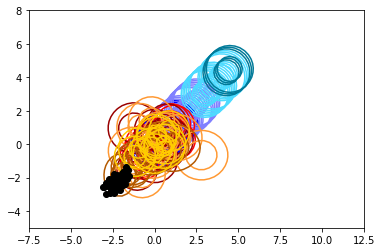

In [13]:


def gaussian_2d(x, y, dist):
    return dist.pdf([x,y])

gaussian_2d_v = np.vectorize(gaussian_2d)


def plot_gauss_2d(mean, cov, xlim=(-2.0, 2.0), ylim=(-2.0, 2.0), colors='k'):
    mv = multivariate_normal(mean=mean, cov=cov)
    x = np.linspace(*xlim)
    y = np.linspace(*ylim)
    X, Y = np.meshgrid(x, y)
    Z = gaussian_2d_v(X, Y, mv)
    CS = plt.contour(X, Y, Z, 2, colors=colors)
    #fmt = {CS.levels[0]: '95%', CS.levels[1]: '99%'}
    #plt.clabel(CS, fmt=fmt)
    
plt.figure()
plt.axis('equal')
xlim = (-5, 10)
ylim = (-5, 8)
# plot_gauss_2d(mean=[0,1], cov=[[1,0.5],[0.5,1]])
# plot_gauss_2d(mean=[1,0], cov=[[1,-0.5],[-0.5,1]])

component_parameters

def list_repeat(given_list, repeat_factor):
    return_list = []
    for item in given_list:
        return_list.extend([item]*repeat_factor)
    return return_list


colors_given_list = ['#0000ff', '#8080ff', '#4ddbff', '#007a99', '#00cc00', '#008000']
colors_learned_list = ['#ff0000', '#990000', '#ff9933', '#b35900', '#ffcc00', '#ff6633']


colors_given = list_repeat(colors_given_list, n_states*n_comp_per_state)
colors_learned = list_repeat(colors_learned_list, n_states*n_comp_per_state)


print(len(component_parameters_flat))
print(len(colors_given))
print(len(learned_means))
print(len(colors_learned))

print(learned_means)
print(learned_vars)



# Plot gaussians used to generate data
_ = [ plot_gauss_2d(mean=comp[0], cov=comp[1], xlim=xlim, ylim=ylim, colors=color) for comp, color in zip(component_parameters_flat, colors_given)]

# Plot gaussians learned from data
_ = [ plot_gauss_2d(mean=mean, cov=[[var[0],0],[0,var[1]]], xlim=xlim, ylim=ylim, colors=color) for mean, var, color in zip(learned_means, learned_vars, colors_learned)]

# Plot data
plt.plot(mfccs[:,0], mfccs[:,1], 'ko')

In [15]:
elbo

[-3.1840376376386885, -1.9478404265910396, -2.2716399034235284]